# Run this cell

#### To do:
 - Try doing HP, Rect, LP and compare to the other method. 
 - What does the new frequencies mean? Can they be used to look for interesting frequencies?
 - Compare the first and last intervals. Spectral kurtosis development? Did they do that in the paper I am thinking of? 

In [102]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import numpy as np
import pandas as pd
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import sys, os
from numpy import savez_compressed
from numpy import load

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
print("ROOT", ROOT_PATH)
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/utils/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)

import functions as f

module_path = os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)


%autoreload
import wt_data
import ff_transform
import explore_fft_time_data
import envelope
import build_dataset

ROOT /Users/stianismar/Dropbox/gitProsjekter/master-thesis/src
ROOT /Users/stianismar/Dropbox/gitProsjekter/master-thesis/src


# Run from here

In [40]:
COMPONENT_NAME = 'GbxHssRr'
# ['GbxHssRr;0,0102;m/s2']

# Select WT and component and load data

In [ ]:
intervals_vibrations_wt4, intervals_times_wt4, df_intervals_data_wt04, intervals_peak_arrays_wt04 = build_dataset.load_wt_high_freq_analysis("WTG04",'GbxHssRr;0,0102;m/s2')

In [ ]:
# Saving vibrations
savez_compressed('../../sensor_data/intervals_vibrations_wt04.npz', intervals_vibrations_wt4)

# Saving timestamps
savez_compressed('../../sensor_data/intervals_times_wt04.npz', intervals_times_wt4)

# Saving operating data
df_intervals_data_wt04.to_csv('../../sensor_data/df_intervals_data_wt04.csv.gz', compression='gzip')

del intervals_vibrations_wt4, intervals_times_wt4, df_intervals_data_wt04


In [ ]:
savez_compressed('../../sensor_data/intervals_peak_arrays_wt04.npz', intervals_peak_arrays_wt04)

# LOAD

In [86]:
intervals_peak_arrays_wt04 = load('../../sensor_data/intervals_peak_arrays_wt04.npz',allow_pickle=True)

In [87]:
intervals_peak_arrays_wt04 = intervals_peak_arrays_wt04['arr_0']

In [88]:
# Load compressed data
df_intervals_data_wt04 = pd.read_csv('../../sensor_data/df_intervals_data_wt04.csv.gz', compression='gzip')
vib_signal_wt4 = load('../../sensor_data/intervals_vibrations_wt04.npz')
times_wt4 = load('../../sensor_data/intervals_times_wt04.npz')
vib_signal_wt4 = vib_signal_wt4['arr_0']
times_wt4 = times_wt4['arr_0']

# Spectrogram

(0, 8)

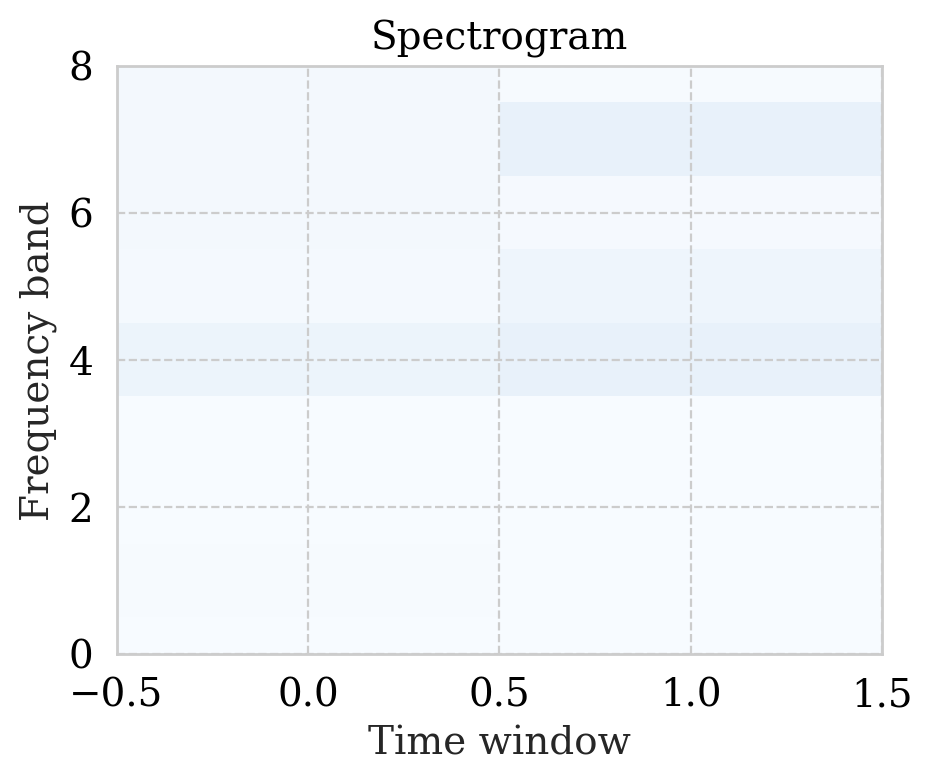

In [45]:
from scipy import signal
freqs, times, spectrogram = signal.spectrogram(vib_signal_wt4[0][0:500])

plt.figure(figsize=(5, 4))
plt.imshow(spectrogram, aspect='auto', cmap='Blues', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.tight_layout()
plt.ylim(0,8)


# Bandpass method (Bandpass + RECT + LP)

## Select lowcut and highcut

3.90625e-05

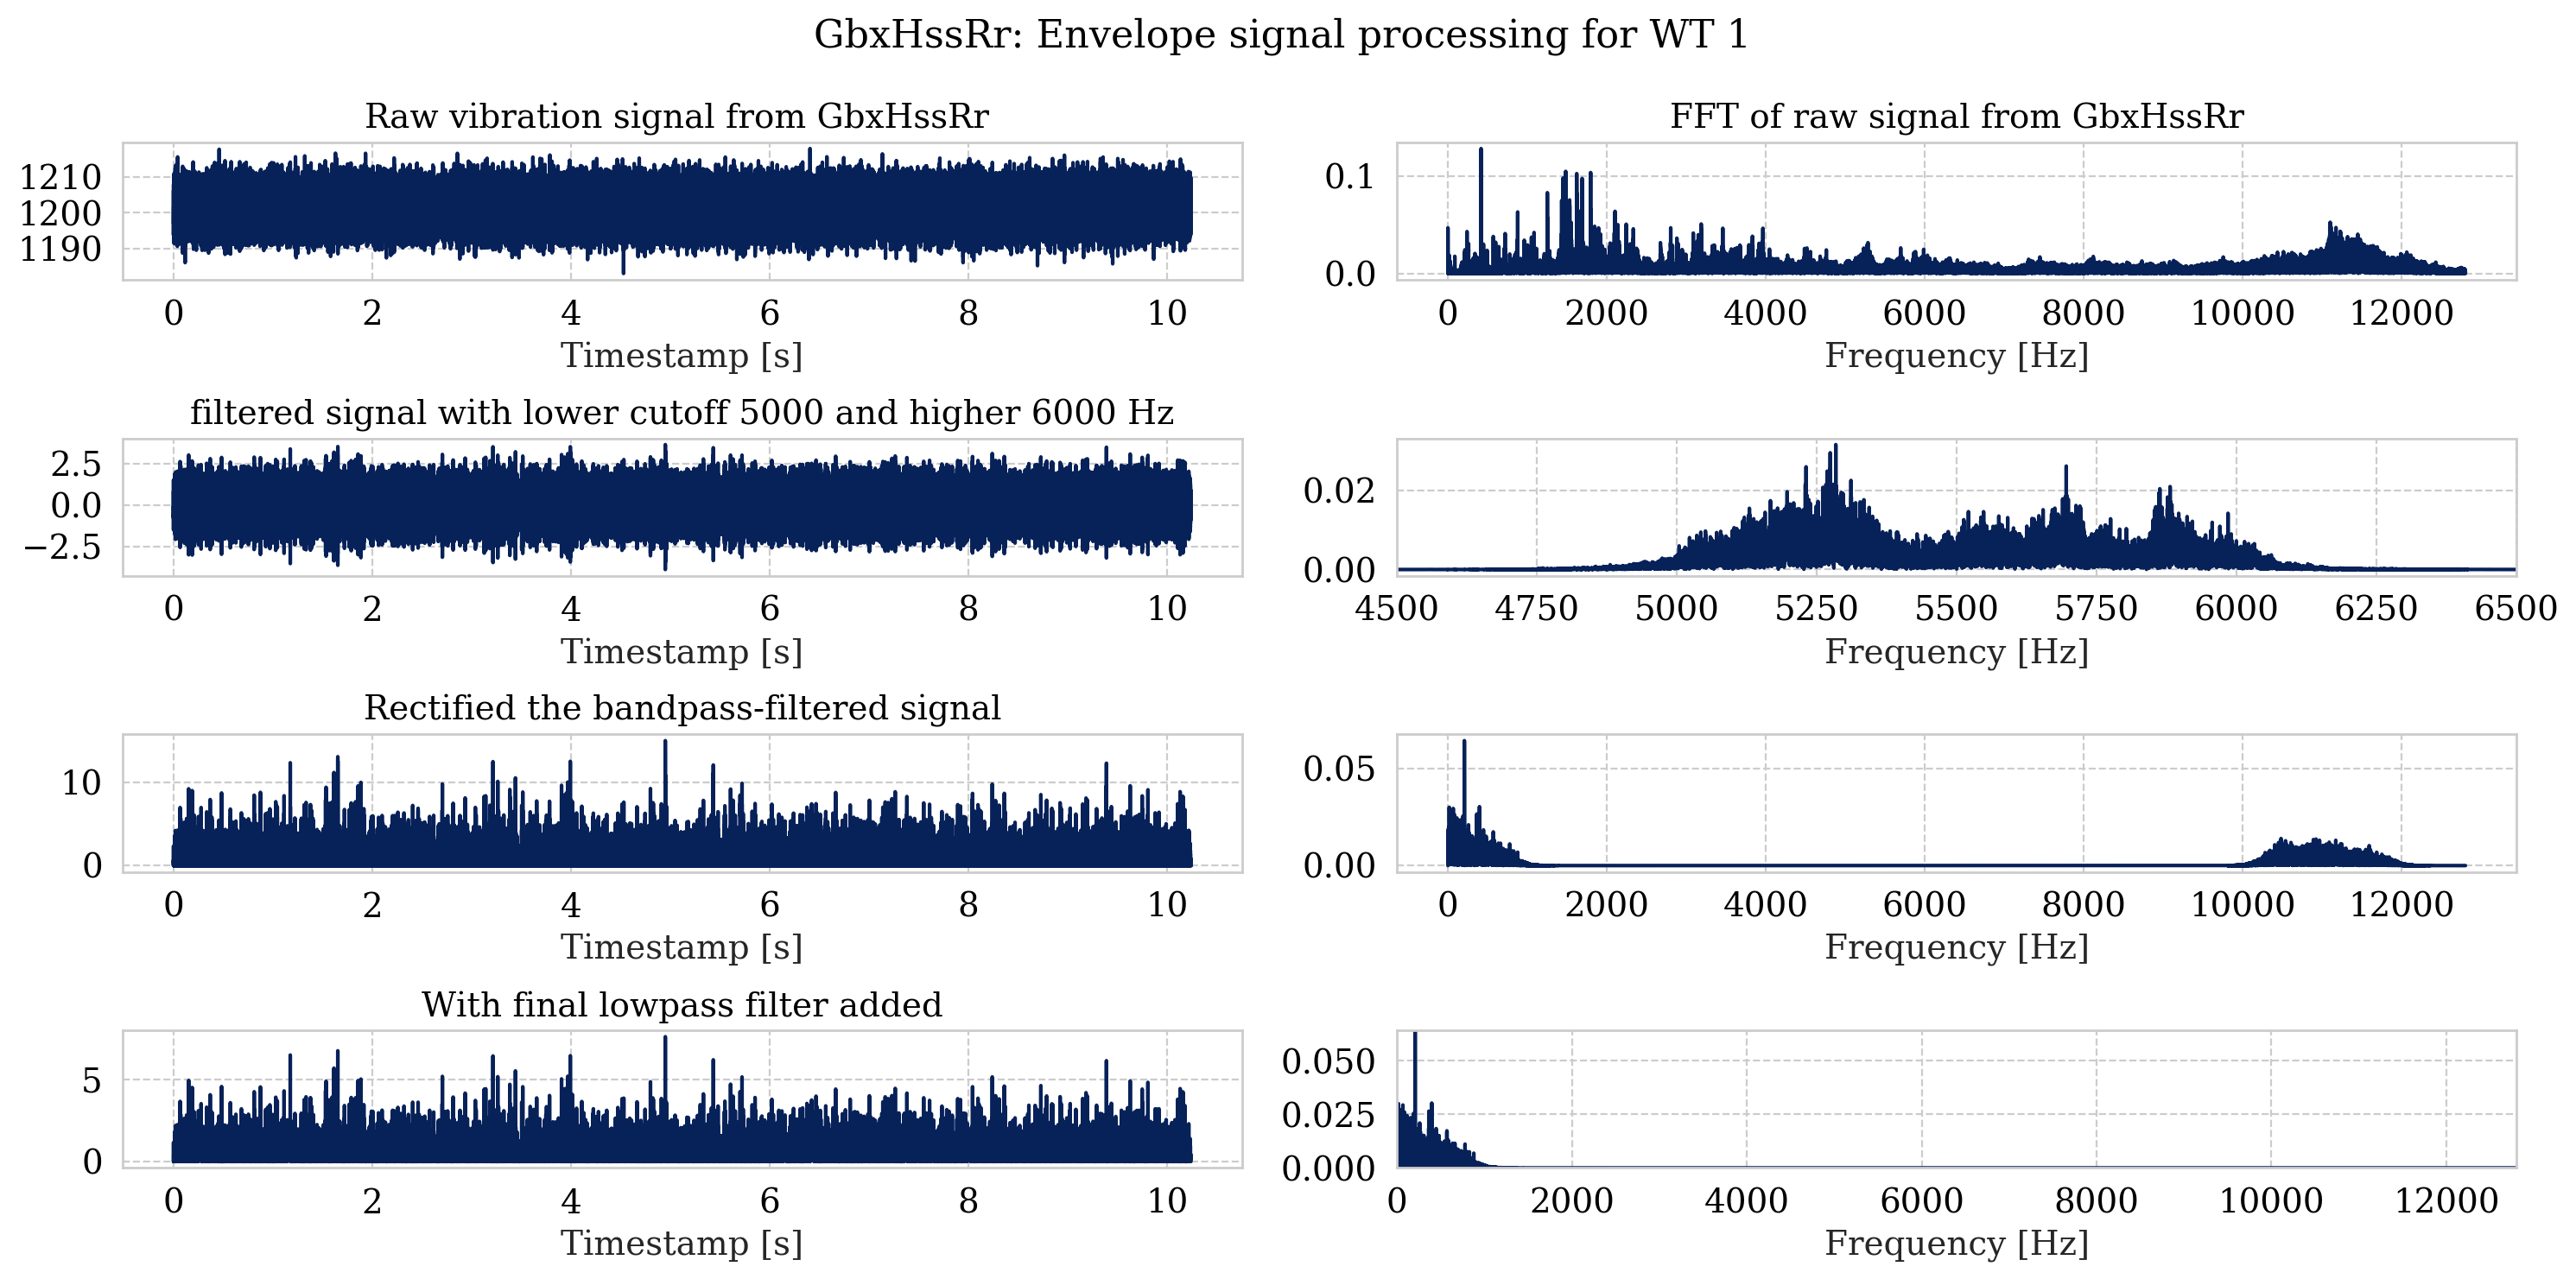

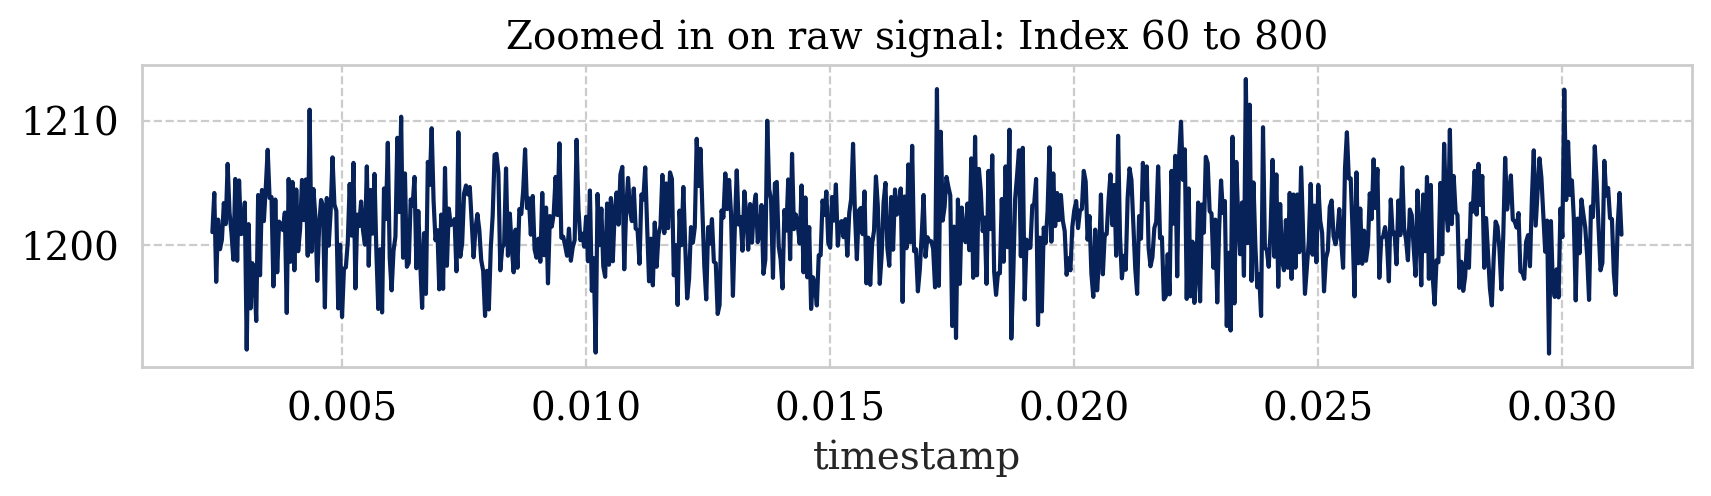

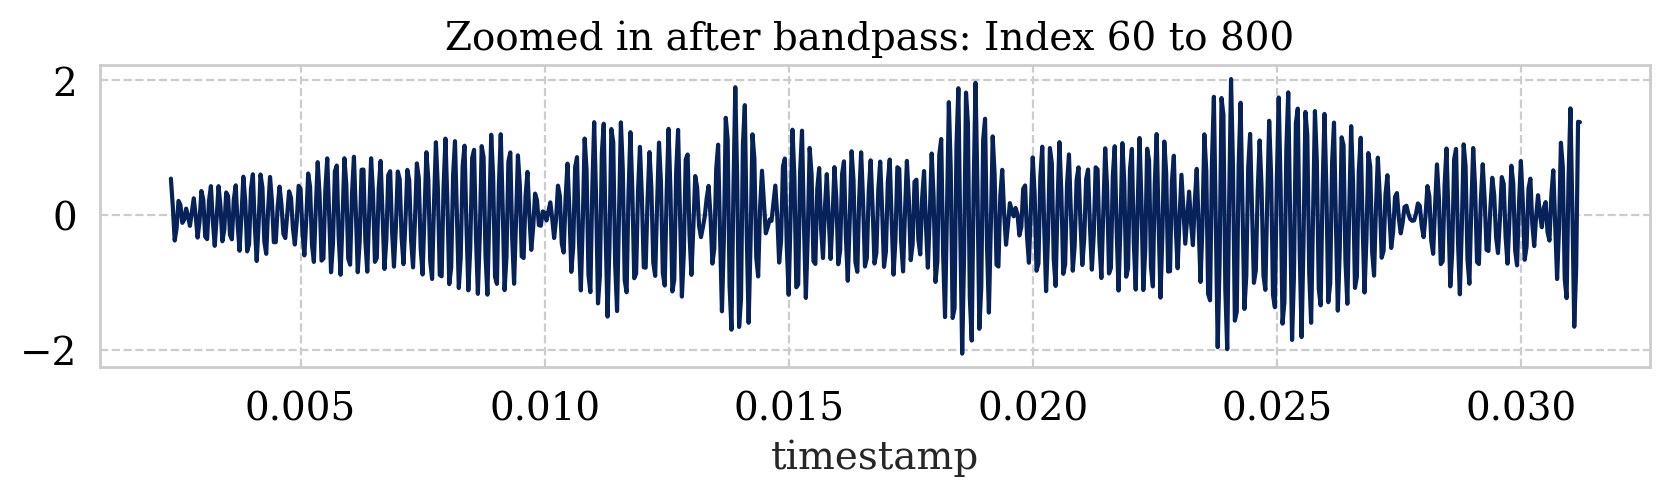

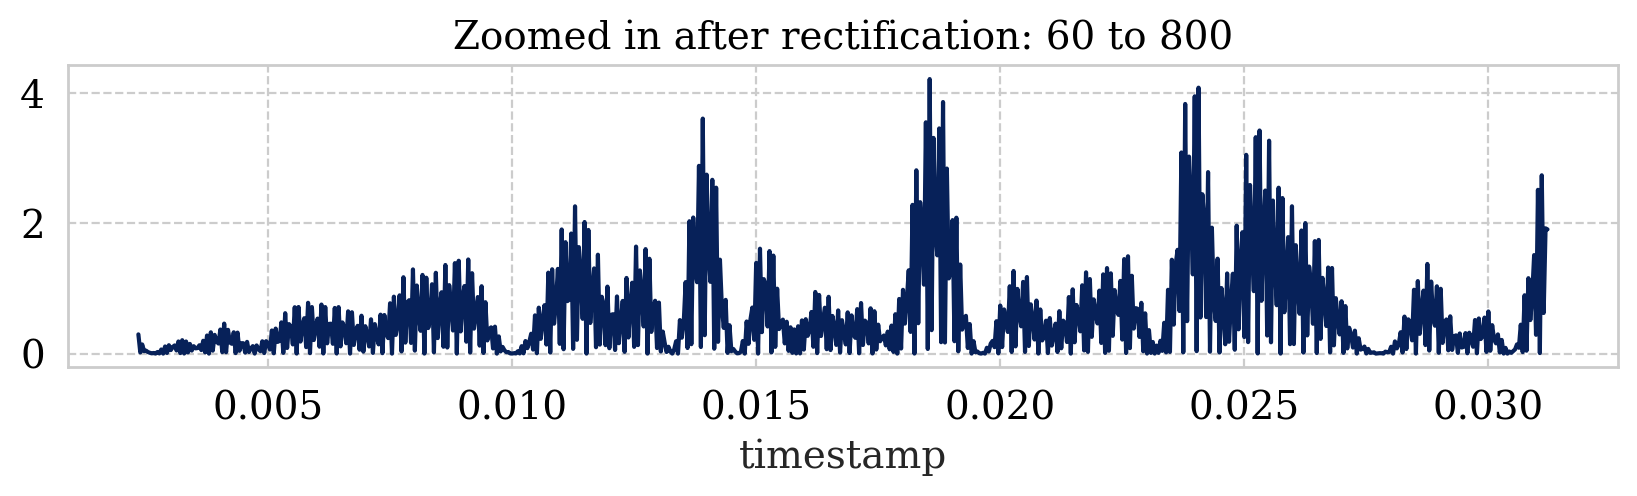

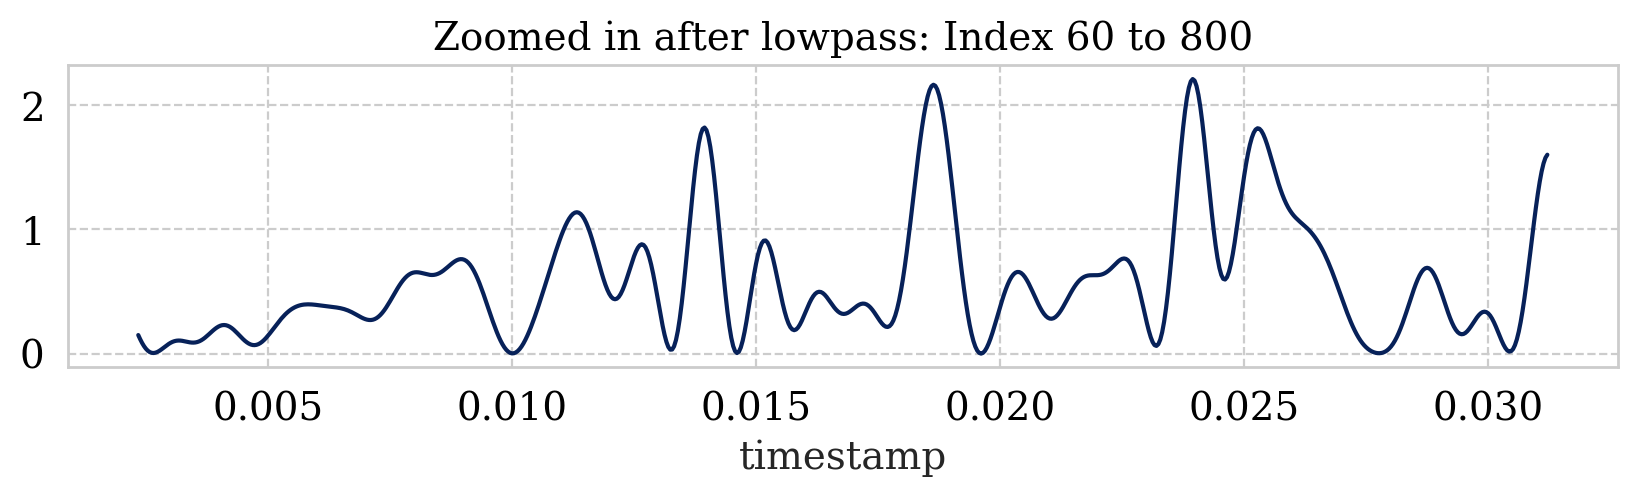

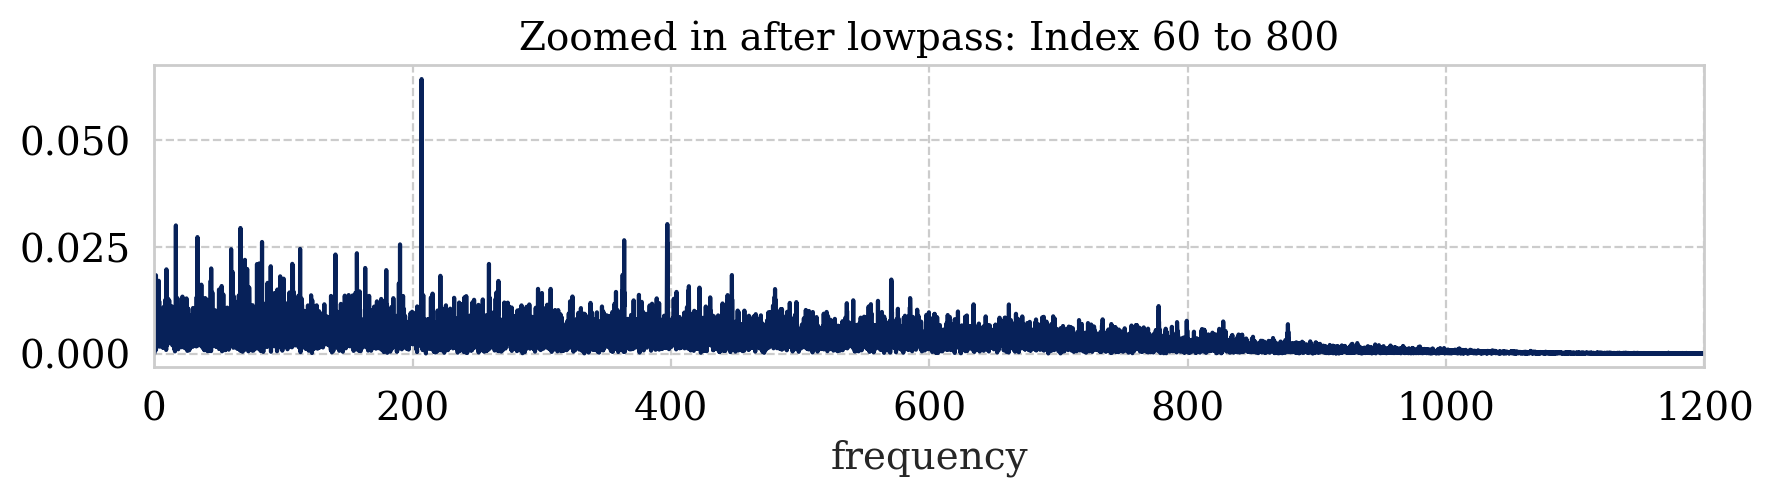

In [105]:
# Run just one:

lowcut = 5000
highcut = 6000
lowcut_final_lp = 2000

all_time_signals, all_fft_objects = envelope.perform_envelope_process(
        'WT 1',
        times_wt4[0],
        vib_signal_wt4[0],
        'GbxHssRr',
        lowcut,
        highcut,
        plot=True,
        square=True,
        plot_low=60,
        plot_high=800,
        lowcut_final_lp = lowcut_final_lp
    )


    # Do something with all_time_signals, all_fft_objects... Feature extraction/analysis of development

In [29]:
fs, _, _, _  = envelope.get_sampling_freq(vib_signal_wt4[0],times_wt4[0])
fs

25600.097656622533

# Looping through all samples

In [82]:
lowcut = 5000
highcut = 6000
lowcut_final_lp = 2000
#steps = np.arange(0,len(times_wt4), 10)

final_vibs = []
for i in range(len(vib_signal_wt4)):
    all_time_signals, all_fft_objects = envelope.perform_envelope_process(
        'WT 1',
        times_wt4[i],
        vib_signal_wt4[i],
        'GbxHssRr',
        lowcut,
        highcut,
        plot=False,
        square=True,
        plot_low=60,
        plot_high=800,
        lowcut_final_lp = lowcut_final_lp
    )
    final_vibs.append(all_time_signals[-1])
    
    # Do something with all_time_signals, all_fft_objects... Feature extraction/analysis of development

TypeError: len() of unsized object

In [7]:
len(final_vibs[0])

262144

## Saving all new signal for wt

In [8]:
savez_compressed(f'../../sensor_data/all_enveloped_wt04_{lowcut}_{highcut}.npz', final_vibs)
del final_vibs

### Note on filtering after highpass/lowpass: filtfilt vs. lfilt
filtfilt runs the filter forward and backward in time across the data, which produces a zero-phase response.  No frequencies are shifted in time, only attenuated.  Filtering backwards in time requires full knowledge of the future, though, so it can't be used in "online" real-life applications, only for offline processing of recordings of signals.  This would be best for something like smoothing of a financial or weather data series, for instance, where you don't want any phase shift.

# Implementation of Conventional Envelope process (HP + RECT + LP)

In [ ]:
def plot_real_enveloping_process(rows, cols, comp_name, raw_signal, processed_signals,timestamps, lowcut, highcut):
    fig, ax = plt.subplots(rows, cols,figsize=(15,10))
    fig.suptitle(f'{comp_name}: Envelop signal processing ',fontsize=16, y=1.05)

    # Raw signal
    ax[0,0].plot(timestamps,raw_signal)
    ax[0,0].set_title(f"Raw vibration signal from {COMPONENT_NAME} ")
    perform_fft(raw_signal,timestamps,ax[0,1])
    ax[0,1].set_xlabel("Frequency [Hz]")
    ax[0,1].set_title(f"Raw signal from {COMPONENT_NAME}")

    # Raw + HP
    ax[1,0].plot(timestamps, processed_signals[0])
    ax[1,0].set_title(f' Highpass filter applied with cutoff at {lowcut} Hz')
    perform_fft(processed_signals[0], timestamps, ax[1,1])
    ax[1,1].set_xlabel("Frequency [Hz]")
    ax[1,1].set_xlim(lowcut-500,highcut+500)
    
    # Raw + HP + abs
    ax[2,0].plot(timestamps, processed_signals[1])
    ax[2,0].set_title(f'Rectified the higpass filtered signal')
    perform_fft(processed_signals[1], timestamps, ax[2,1])
    ax[2,1].set_xlabel("Frequency [Hz]")
    ax[2,1].set_xlim(0,1000)   
    
    # Raw + HP + abs + LP
    ax[3,0].plot(timestamps, processed_signals[2])
    ax[3,0].set_title(f' Lowpass filter applied with cutoff at {highcut} Hz')
    perform_fft(processed_signals[2], timestamps, ax[3,1])
    ax[3,1].set_xlabel("Frequency [Hz]")
    # ax[3,1].set_xlim(0,1000)   
    
    plt.tight_layout()
    plt.margins(0)

In [ ]:
def perform_real_envelope_process(timestamps, interval_signal, fs, COMPONENT_NAME, lowcut,highcut,order = 5,):
    fs, _, _ ,_ =  get_sampling_freq(interval_signal,timestamps)
    
    highpass_filtered = butter_hp_filter(interval_signal,lowcut, fs, order=5)
    highpass_filtered_rect = abs(highpass_filtered)
    highpass_filtered_rect_lowpass = butter_lp_filter(highpass_filtered_rect, highcut, fs, order=5)
    
    processed_signals = [highpass_filtered,highpass_filtered_rect,highpass_filtered_rect_lowpass]
    # Plotting
    plot_real_enveloping_process(4,2,COMPONENT_NAME, interval_signal,processed_signals,timestamps,lowcut,highcut )
    
    # Plotting a selection of zoomed in plots
    df = pd.DataFrame(interval_signal)
    df['timestamp'] = timestamps
    # df.plot.hist(bins=2000)
    df.iloc[60:800].plot.line(x='timestamp',y=0,title="Raw signal: Zoomed in from point 60 to 800",legend=False)
    
    # Plotting a selection of zoomed in plots
    df = pd.DataFrame(highpass_filtered)
    df['timestamp'] = timestamps
    # df.plot.hist(bins=2000)
    df.iloc[60:800].plot.line(x='timestamp',y=0,title="HP filtered signal: Zoomed in from point 60 to 800",legend=False)
    
    df = pd.DataFrame(highpass_filtered_rect)
    df['timestamp'] = timestamps
    # df.plot.hist(bins=2000)
    df.iloc[100:800].plot.line(x='timestamp',y=0,title="HP + rectified filtered signal: Zoomed in from point 60 to 800",legend=False)
    
    df = pd.DataFrame(highpass_filtered_rect_lowpass)
    df['timestamp'] = timestamps
    # df.plot.hist(bins=2000)
    df.iloc[100:800].plot.line(x='timestamp',y=0,title="HP + rectified + LP filtered signal: Zoomed in on index 60 to 800",legend=False)
    return interval_signal, processed_signals

In [ ]:
from scipy.signal import butter, lfilter,filtfilt

def butter_hp(lowcut, fs, order=5):
    nyq = 0.5 * fs
    w = lowcut / nyq
    b, a = butter(order, w, btype='highpass')
    return b, a

def butter_hp_filter(data, lowcut, fs, order=5):
    b, a = butter_hp(lowcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Lowpass

from scipy.signal import butter, lfilter,filtfilt

def butter_lp(highcut, fs, order=5):
    nyq = 0.5 * fs
    w = highcut / nyq
    b, a = butter(order, w, btype='lowpass')
    return b, a

def butter_lp_filter(data, highcut, fs, order=5):
    b, a = butter_lp(highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Running functions

## lowcut = 4000, highcut = 60000

In [ ]:
lowcut = 4000
highcut =  6000
raw, processed_signals = perform_real_envelope_process(times_wt4[0], vib_signal_wt4[0], fs,'GbxHssRr', lowcut, highcut)

In [ ]:
lowcut = 5000
highcut =  6000
raw, processed_signals = perform_real_envelope_process(times_wt4[-1], vib_signal_wt4[-1], fs,'GbxHssRr', lowcut, highcut)

In [ ]:
lowcut = 5000
highcut =  6000
raw, processed_signals = perform_real_envelope_process(times_wt4[0], vib_signal_wt4[0], fs,'GbxHssRr', lowcut, highcut)

In [ ]:
lowcut = 5000
highcut =  6000
raw, processed_signals = perform_real_envelope_process(times_wt4[-1], vib_signal_wt4[-1], fs,'GbxHssRr', lowcut, highcut)

df  = pd.DataFrame(processed_signals[-1])
df['Timestamps'] = times_wt4[-1]

In [ ]:
df[60:800].plot(y=0,x='Timestamps',title="testing",legend=False)

In [ ]:
lowcut = 5000
highcut =  6000
raw, processed_signals = perform_real_envelope_process(times_wt4[-1], vib_signal_wt4[-1], fs,'GbxHssRr', lowcut, highcut)

df  = pd.DataFrame(processed_signals[-1])
df['Timestamps'] = times_wt4[-1]

(array([2, 1, 0]), array([1, 2, 3, 4]))

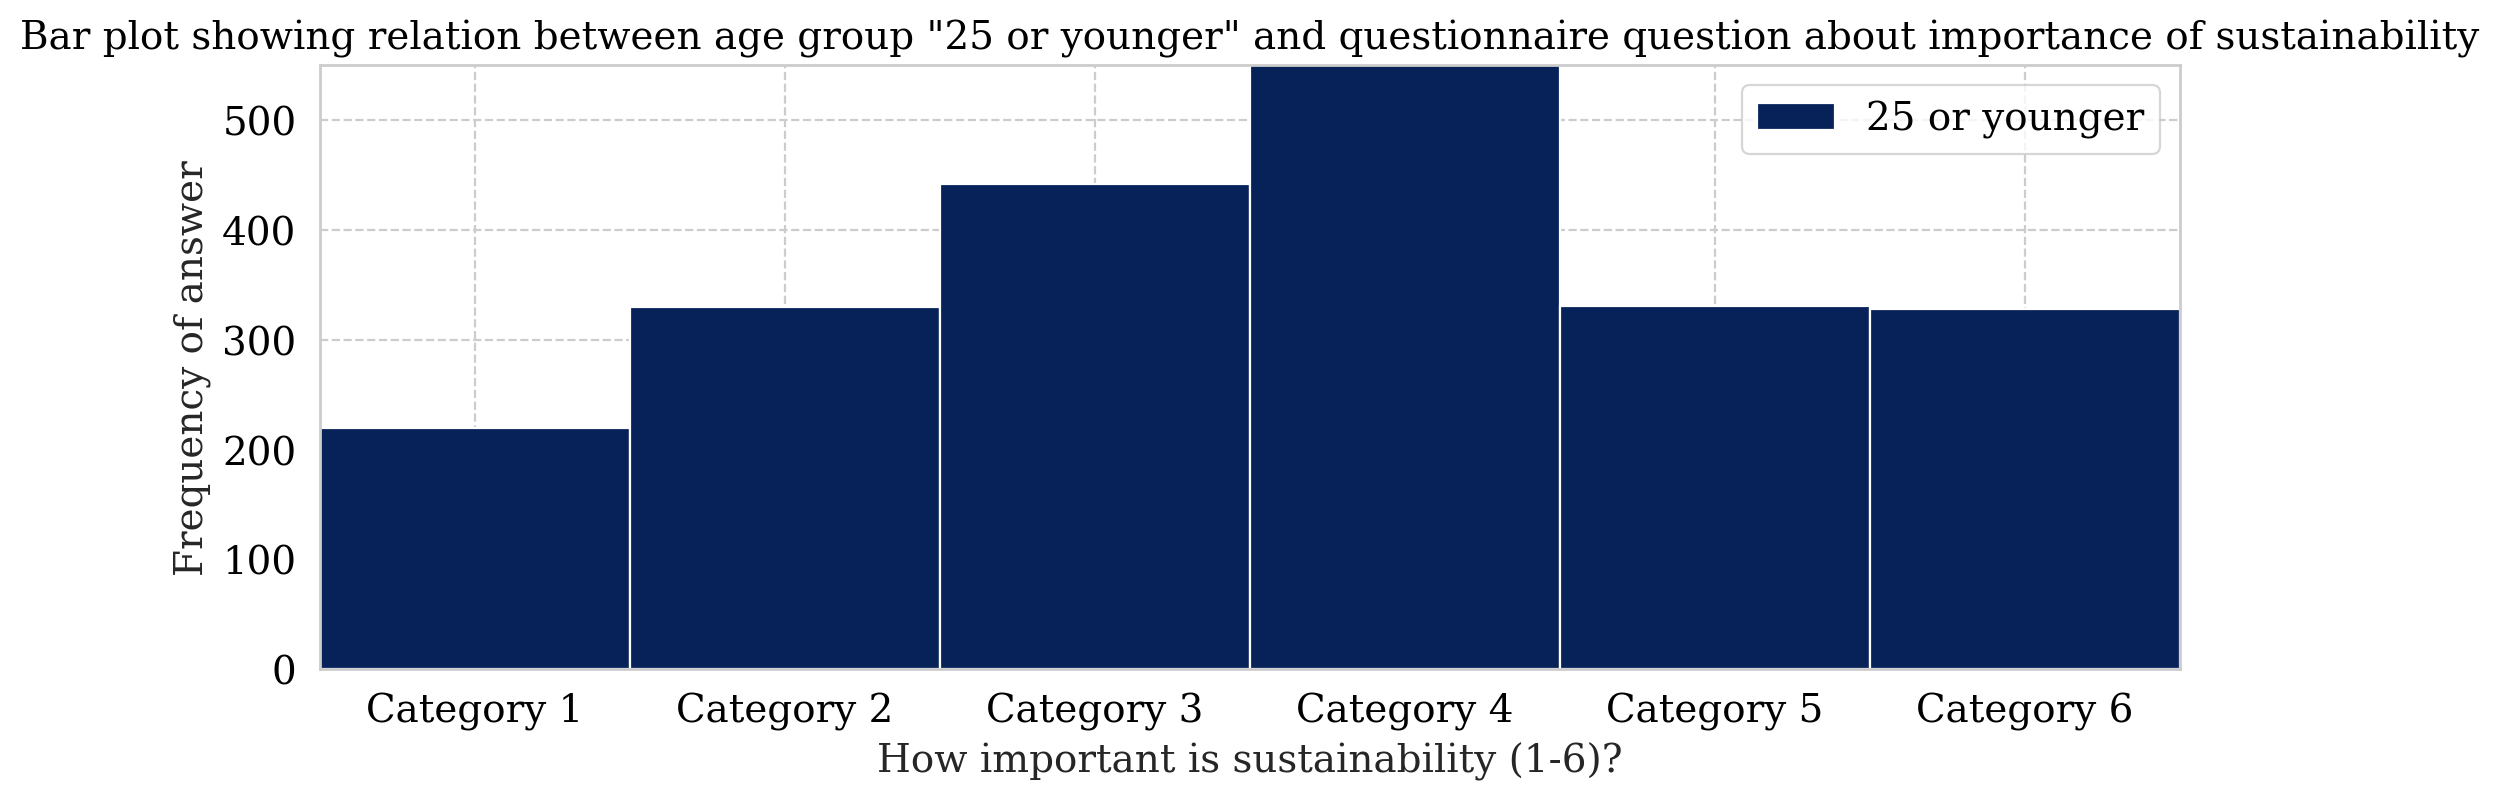

In [74]:
# How important is sustainability to you?
ax = plt.subplot(111)

g1 = [6,6,5,4,2,1]
g2 = [6,5,2]
g3 = [4,5,6,3]
g4 = [1,1,1,3]

x = [1,2,3,4,5,6]
x_skewed = [1-0.3,2-0.3,3-0.3,4-0.3,5-0.3,6-0.3]
ax.bar(x,[220,330,442,550,331,328],width=1)

# ax.bar(x_skewed,[2/len(g3),2/len(g3),4/len(g3),2/len(g3),6/len(g3),1/len(g3)],width=0.2)
plt.ylabel("Frequency of answer")
plt.xlabel("How important is sustainability (1-6)?")
plt.xticks([1,2,3,4,5,6],["Category 1","Category 2","Category 3","Category 4","Category 5","Category 6"])
plt.legend(['25 or younger'])
plt.title('Bar plot showing relation between age group "25 or younger" and questionnaire question about importance of sustainability')
plt.margins(0)

bins=[0, 1, 2, 3]

np.histogram([1, 2, 1], bins=[1,2, 3, 4])



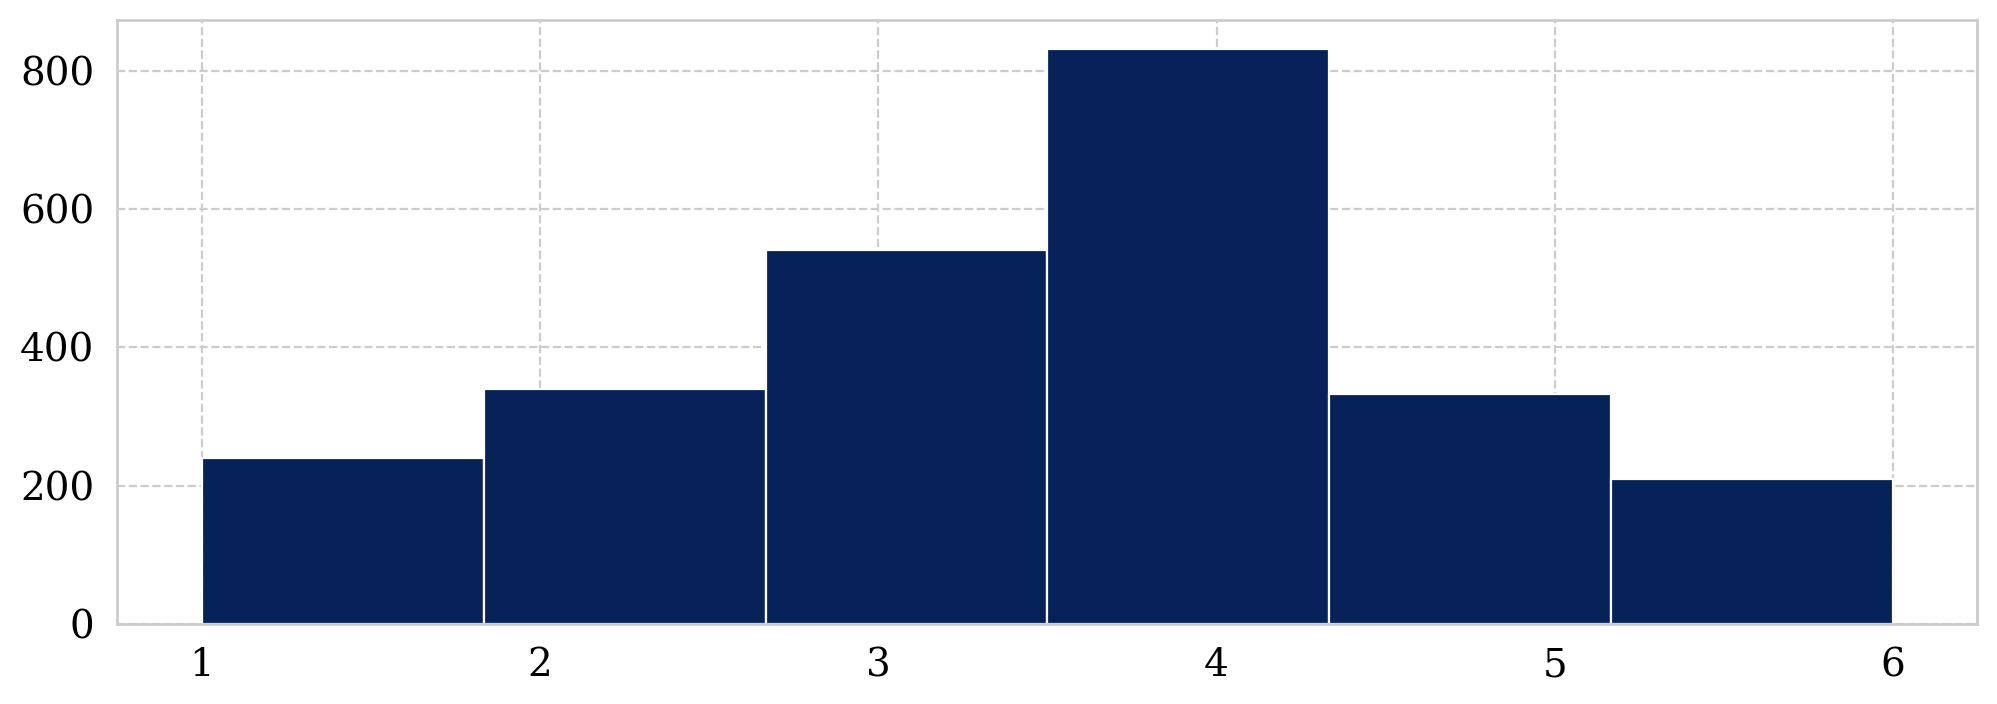

In [72]:
import matplotlib.pyplot as plt

a1 = np.repeat(1,240)
a2 = np.repeat(2,340)
a3 = np.repeat(3,541)
a4 = np.repeat(4,832)
a5 = np.repeat(5,332)
a6 = np.repeat(6,210)


b = np.concatenate([a1,a2,a3,a4,a5,a6])



plt.hist(b, bins = 6)
plt.show()